<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap
import jax_cosmo as jc
from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, make_ode_fn
from montecosmo.bricks import lpt as mylpt, Planck18
from montecosmo.models import get_pk_fn

feynmangpu04.cluster.local
gpu


2024-07-17 18:29:41.137686: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
mesh_size = 256*np.array([1,1,1])
# mesh_size = 128*np.array([1,1,1])
# mesh_size = 64*np.array([1,1,1])
box_size  = np.array([640.,640.,640.])

multipoles = [0,2,4]
pk_fn = get_pk_fn(mesh_size, box_size, multipoles=multipoles)
zeros_mesh = jnp.zeros(mesh_size)

def likelihood_model(rng_key, loc_mesh, mesh_size, box_size, galaxy_density, obs_name):
    """
    A likelihood for cosmological model.

    Return an observed mesh sampled from a location mesh with observational variance.
    """
    sigma2 = 1.

    if obs_name == 'mesh':
        # Normal noise
        sigma2 /= (galaxy_density * (box_size / mesh_size).prod())
        # obs_mesh = sample('obs', dist.Normal(loc_mesh, jnp.sqrt(sigma2)))
        obs_mesh = loc_mesh + jnp.sqrt(sigma2) * jr.normal(rng_key, mesh_size)
        return obs_mesh
    
    elif obs_name == 'pk':
        # Anisotropic power spectrum covariance, cf. [Grieb+2016](http://arxiv.org/abs/1509.04293)
        multipoles = jnp.array([0,2,4])
        sli_multip = slice(1,1+jnp.shape(multipoles)[0])
        loc_pk, Nk = get_pk_fn(mesh_size, box_size, multipoles=multipoles, kcount=True)(loc_mesh)
        # sigma2 *= ((2*multipoles[:,None]+1)/galaxy_density)**2 / Nk
        sigma2 *= 2*(2*multipoles[:,None]+1) * (1 / galaxy_density**2 + 2*loc_pk[1]/galaxy_density) / Nk

        loc_pk = loc_pk.at[1].add(1/galaxy_density) # add shot noise to the mean power spectrum
        # obs_pk = loc_pk.at[sli_multip].set(sample('obs', dist.Normal(loc_pk[sli_multip], jnp.sqrt(sigma2))))
        obs_pk = loc_pk.at[sli_multip].set(loc_pk[sli_multip] + jnp.sqrt(sigma2) * jr.normal(rng_key, loc_pk[sli_multip].shape))
        return obs_pk

def run_simulation(rng_key, cosmology, obs_name):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    # rng_key, init_key = jr.split(rng_key)
    init_key = jr.key(0)
    # mesh = linear_field(mesh_size, box_size, pk_fn, seed=init_key)
    mesh = 100*jr.normal(init_key, mesh_size)

    # # Create particles
    # particles = jnp.indices(mesh_size).reshape(3,-1).T

    # # Initial displacement
    # cosmology._workspace = {}  # FIX ME: this a temporary fix
    # dx, p, f = mylpt(cosmology, mesh, particles, a=.5)

    obs = likelihood_model(rng_key, mesh, mesh_size, box_size, galaxy_density=1e-3, obs_name=obs_name)
    return obs

In [5]:
cosmology = Planck18()
print(f"Fiducial {cosmology}")
a_lpt, a_obs = 0.1, 0.5
rng_key = jr.key(1)
n = 60

res = vmap(partial(run_simulation, cosmology=cosmology, obs_name='mesh'))(jr.split(rng_key, n))
pk_mesh = jit(vmap(pk_fn))(res)
pk_spect = vmap(partial(run_simulation, cosmology=cosmology, obs_name='pk'))(jr.split(rng_key, n))

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


[[[ 0.          1.          1.         ... -0.99999994 -1.
   -1.        ]
  [ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]
  [ 0.          0.44721362  0.7071068  ... -0.8320503  -0.7071068
   -0.44721362]
  ...
  [ 0.          0.3162278   0.5547002  ... -0.70710677 -0.5547002
   -0.3162278 ]
  [ 0.          0.44721362  0.7071068  ... -0.8320503  -0.7071068
   -0.44721362]
  [ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]]

 [[ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]
  [ 0.          0.5773503   0.8164967  ... -0.90453404 -0.8164967
   -0.5773503 ]
  [ 0.          0.40824834  0.6666666  ... -0.80178374 -0.6666666
   -0.40824834]
  ...
  [ 0.          0.30151135  0.53452253 ... -0.68824726 -0.53452253
   -0.30151135]
  [ 0.          0.40824834  0.6666666  ... -0.80178374 -0.6666666
   -0.40824834]
  [ 0.          0.5773503   0.8164967  ... -0.90453404 -0.8164967
   -0.5773503 ]]

 [[

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


[[[ 0.          1.          1.         ... -0.99999994 -1.
   -1.        ]
  [ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]
  [ 0.          0.44721362  0.7071068  ... -0.8320503  -0.7071068
   -0.44721362]
  ...
  [ 0.          0.3162278   0.5547002  ... -0.70710677 -0.5547002
   -0.3162278 ]
  [ 0.          0.44721362  0.7071068  ... -0.8320503  -0.7071068
   -0.44721362]
  [ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]]

 [[ 0.          0.7071068   0.89442724 ... -0.9486834  -0.89442724
   -0.7071068 ]
  [ 0.          0.5773503   0.8164967  ... -0.90453404 -0.8164967
   -0.5773503 ]
  [ 0.          0.40824834  0.6666666  ... -0.80178374 -0.6666666
   -0.40824834]
  ...
  [ 0.          0.30151135  0.53452253 ... -0.68824726 -0.53452253
   -0.30151135]
  [ 0.          0.40824834  0.6666666  ... -0.80178374 -0.6666666
   -0.40824834]
  [ 0.          0.5773503   0.8164967  ... -0.90453404 -0.8164967
   -0.5773503 ]]

 [[

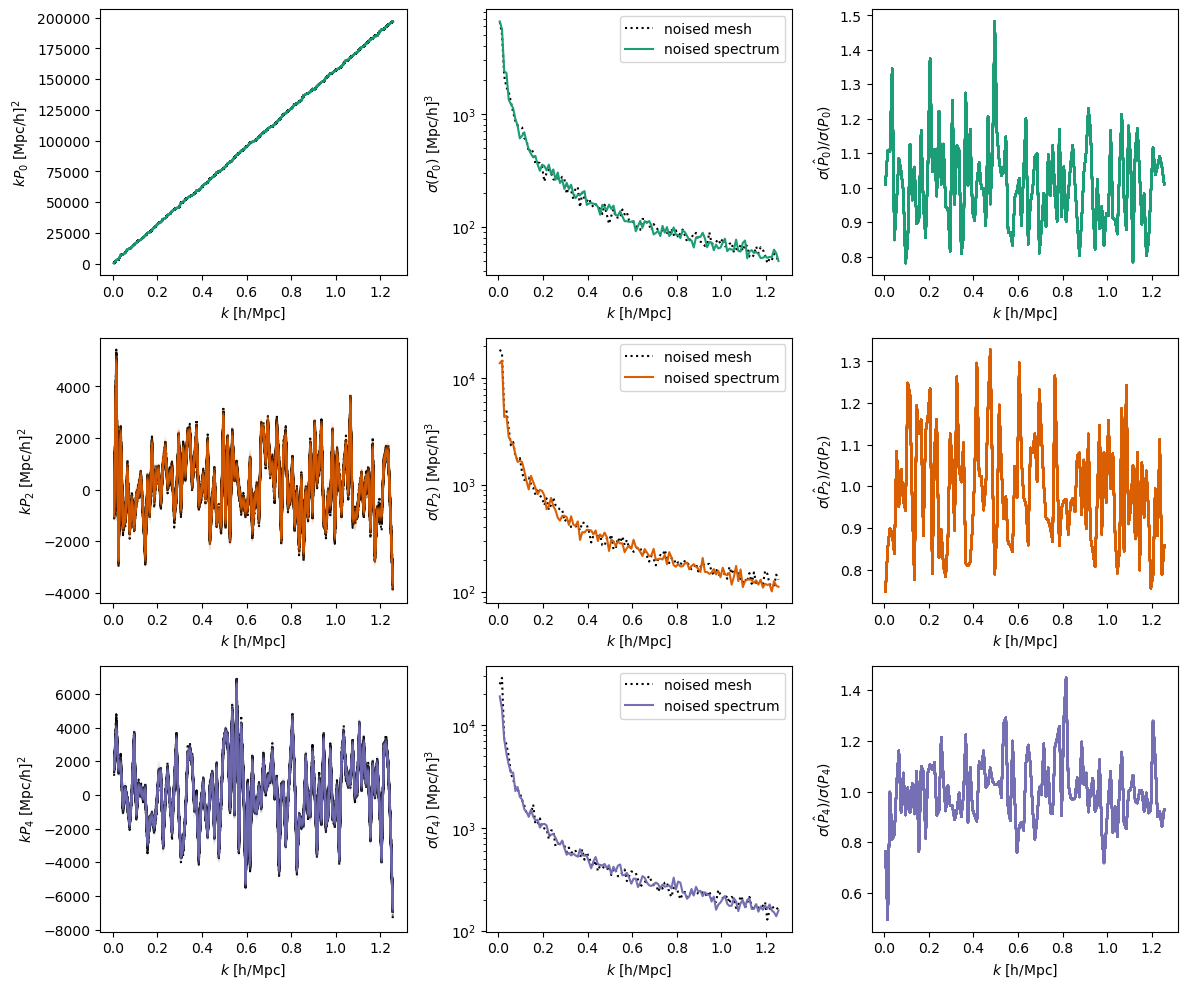

In [ ]:
cmap = plt.get_cmap('Dark2')
# relerr = lambda x, true: jnp.abs(x-true)/jnp.abs(true)
relerr = lambda x, true: x/true
plt.figure(figsize=(12,10))
n_col = 3
for i_ell, ell in enumerate(multipoles):
    plt.subplot(3,n_col,n_col*i_ell+1)
    plt.plot(pk_mesh[:,0].T, (pk_mesh[:,0]*pk_mesh[:,i_ell+1]).T, ':k')
    plt.plot(pk_spect[:,0].T, (pk_spect[:,0]*pk_spect[:,i_ell+1]).T, color=cmap(i_ell), alpha=.1)
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{ell}$ [Mpc/h]$^2$")
    # plt.plot(pk_spect[:,0].T, relerr(pk_spect[:,0]*pk_spect[:,i_ell+1], pk_mesh[:,0]*pk_mesh[:,i_ell+1]).T, color=cmap(i_ell))
    plt.subplot(3,n_col,n_col*i_ell+2)
    plt.semilogy(pk_mesh[0,0], pk_mesh[:,i_ell+1].std(0), ':k', label="noised mesh")
    plt.semilogy(pk_spect[0,0], pk_spect[:,i_ell+1].std(0), color=cmap(i_ell), label="noised spectrum")
    # plt.semilogy(pk_mesh[0,0], pk_mesh[0,0]*pk_mesh[:,i_ell+1].std(0), ':k', label="noised mesh")
    # plt.semilogy(pk_spect[0,0], pk_mesh[0,0]*pk_spect[:,i_ell+1].std(0), color=cmap(i_ell), label="noised spectrum")
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$\\sigma (P_{ell})$ [Mpc/h]$^3$")
    plt.legend()
    plt.subplot(3,n_col,n_col*i_ell+3)
    plt.plot(pk_spect[:,0].T, relerr(pk_spect[:,i_ell+1].std(0), pk_mesh[:,i_ell+1].std(0)), color=cmap(i_ell))
    # plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$|\\sigma (\\hat P_{ell})/\\sigma (P_{ell}) -1|$")
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$\\sigma (\\hat P_{ell})/\\sigma (P_{ell})$")
plt.tight_layout()